## SCDV encoder for document mixture clustering

In [107]:
import sys
sys.path.insert(0, "/work/04233/sw33286/AIDA-SCRIPTS")

### Build SCDV

In [108]:
import os
import random
import dill
import numpy as np

from helpers import Indexer, batch
from itertools import chain, product
from collections import defaultdict

In [109]:
nyt_code_dir = "/work/04233/sw33286/AIDA-DATA/nyt_eng_salads_code/"
FILE_NAMES = os.listdir(nyt_code_dir)

info_path = "/work/04233/sw33286/AIDA-DATA/nyt_eng_salads_info/indexer_word2emb_100k.p"
indexer100k, word2emb100k = dill.load(open(info_path, 'rb'))

In [110]:
# Document reader for nyt_story_salad dataset.

import os
import dill
from itertools import chain

class NytDocGetter:
    
    def __init__(self, doc_dir):
        self.doc_dir = doc_dir
        self.filenames = os.listdir(self.doc_dir)
        self.curr_idx = 0
        self.size = len(self.filenames)
    
    def reset(self):
        self.curr_idx = 0
        
    def has_next(self):
        return self.curr_idx < self.size
    
    def get_doc(self):
        if self.has_next():
            filename = self.filenames[self.curr_idx]
            self.curr_idx += 1
            _, _, salad_code = dill.load(open(self.doc_dir+filename, 'rb'))
            return list(chain.from_iterable(salad_code))
        else:
            raise EOFError("End of document list. Please reset document getter.")

In [111]:
import time
import numpy as np
from collections import Counter
from sklearn.mixture import GMM

class SCDV:
    
    def __init__(self, doc_getter, indexer, word2emb,
                       n_gmm_comps=100, n_gmm_iters=50, sparse_p=0.04): # best hyperparams in original paper.
        self.doc_getter = doc_getter
        self.indexer = indexer
        self.vocab_size = len(self.indexer)
        self.word2emb = word2emb
        self.wordemb_dim = len(self.word2emb.get('UNK',self.word2emb['the']))
        self.n_gmm_comps = n_gmm_comps
        self.n_gmm_iters = n_gmm_iters
        self.p = sparse_p
        self.error_fileids = []
        
    def train(self):
        print('... Computing word counts', end=' ')
        start = time.time()
        self._compute_word_count()
        print('(time elapsed = {})'.format(time.time()-start))
        print('... Computing word idfs', end=' ')
        start = time.time()
        self._compute_word_idf()
        print('(time elapsed = {})'.format(time.time()-start))
        print('... Performing GMM clustering', end=' ')
        start = time.time()
        self._gmm_cluster()
        print('(time elapsed = {})'.format(time.time()-start))
        print('... Computing SCDV word representations', end=' ')
        start = time.time()
        self._compute_scdv()
        print('(time elapsed = {})'.format(time.time()-start))
        print('Ready to encode!')
        
    def _compute_word_count(self):
        self.wordcode2count = Counter()
        counter = 0
        while self.doc_getter.has_next():
            try:
                for wordcode in self.doc_getter.get_doc():
                    self.wordcode2count[wordcode] += 1
            except:
                self.error_fileids.append(counter)
            counter += 1
        self.doc_getter.reset()
    
    def _compute_word_idf(self):
        self.wordcode2idf = dict()
        num_docs = self.doc_getter.size
        for wordcode,count in self.wordcode2count.items():
            self.wordcode2idf[wordcode] = np.log(num_docs/count)
    
    def _get_word_emb_mat(self):
        wordemb_mat = []
        for i in range(len(self.indexer)):
            wordemb_mat.append(self.word2emb[self.indexer.get_object(i)])
        return np.array(wordemb_mat)
    
    def _gmm_cluster(self):
        gmm = GMM(n_components=self.n_gmm_comps,covariance_type='tied',init_params='kmeans',n_iter=self.n_gmm_iters)
        wordemb_mat = self._get_word_emb_mat()
        gmm.fit(wordemb_mat)
        self.pred_clus = gmm.predict(wordemb_mat)
        self.pred_prob = gmm.predict_proba(wordemb_mat)
        self._get_clus_given_wordcode = lambda wordcode: self.pred_clus[wordcode]
        self._get_prob_given_wordcode = lambda wordcode: self.pred_prob[wordcode]
    
    def _compute_scdv(self):
        # Compute unsparse word representations.
        self.wordcode2unsp_emb = dict()
        for word,emb in self.word2emb.items():
            wordcode = self.indexer.get_index(word,add=False)
            wcv = np.array([])
            for prob in self._get_prob_given_wordcode(wordcode):
                wcv = np.concatenate([wcv,emb*prob])
            wtv = self.wordcode2idf[wordcode] * wcv
            self.wordcode2unsp_emb[wordcode] = wtv # correction made here
        # Compute sparse word representations.
        dv_min_sum = dv_max_sum = 0
        counter = 0
        while self.doc_getter.has_next():
            dv = np.zeros(self.n_gmm_comps*self.wordemb_dim)
            try:
                for wordcode in self.doc_getter.get_doc():
                    if wordcode>=0 or wordcode<self.vocab_size: # within vocab range.
                        dv += self.wordcode2unsp_emb[wordcode]
                dv_min_sum += dv.min()
                dv_max_sum += dv.max()
            except:
                pass # error already logged in word counting.
            counter += 1
        self.doc_getter.reset()
        a_min = dv_min_sum / self.doc_getter.size
        a_max = dv_max_sum / self.doc_getter.size
        t = (np.abs(a_min) + np.abs(a_max)) / 2
        self.epsilon = (self.p/100) * t # threshold of sparse cut.
        
    def _make_sparse(self, doc_vec):
        return np.array([a_i if np.abs(a_i)>=self.epsilon else 0.0 for a_i in doc_vec])

    def get_doc_vec(self, doc, encode=True, sparse=True):
        if encode:
            doccode = [self.indexer.get_index(word) if self.indexer.contains(word) else self.indexer.get_index('UNK')
                       for word in doc]
        else:
            doccode = doc
        dv = np.zeros(self.n_gmm_comps*self.wordemb_dim)
        for wordcode in doccode:
            dv += self.wordcode2unsp_emb[wordcode]
        if sparse:
            return self._make_sparse(dv)
        return dv  

In [112]:
scdv = SCDV(NytDocGetter(nyt_code_dir), indexer100k, word2emb100k)

In [113]:
%%time

scdv.train()

... Computing word counts (time elapsed = 7523.718257427216)
... Computing word idfs (time elapsed = 0.16323351860046387)
... Performing GMM clustering (time elapsed = 3824.9352333545685)
... Computing SCDV word representations (time elapsed = 15092.62650513649)
Ready to encode!
CPU times: user 3h 9min 24s, sys: 16min 43s, total: 3h 26min 7s
Wall time: 7h 20min 41s


In [114]:
# save_path = "/work/04233/sw33286/AIDA-MODEL-SAVE/SCDV/nyt-v100k-gmm100comp-gmm50iter-p004.p"
# dill.dump(scdv, open(save_path, 'wb'))

### Evaluation

In [16]:
# save_path = "/work/04233/sw33286/AIDA-MODEL-SAVE/SCDV/nyt-v100k-gmm100comp-gmm50iter-p004.p"
# scdv_load = dill.load(open(save_path, 'rb'))

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

In [120]:
# Encoding with trained SCDV engine

def encode(doccode, scdv_coder):
    dv = np.zeros(scdv_coder.n_gmm_comps*scdv_coder.wordemb_dim)
    for wordcode in doccode:
        if wordcode>=0 and wordcode<=100001:
            dv += scdv_coder.wordcode2unsp_emb[wordcode]
    return dv

def to_code(doc, scdv_coder):
    return [scdv_coder.indexer.get_index(word,add=False) for word in doc if scdv_coder.indexer.contains(word)]

def to_sent(code, scdv_coder):
    return ' '.join([scdv_coder.indexer.get_object(c_) for c_ in code])

def get_eval_format(filename, scdv_coder):
    doc_a_code, doc_b_code, salad_code = dill.load(open(nyt_code_dir+filename, 'rb'))
    doc_mix, doc_labels = [], []
    for sentcode in salad_code:
        doc_mix.append(encode(sentcode, scdv_coder))
        if sentcode in doc_a_code:
            doc_labels.append(0)
        else:
            doc_labels.append(1)
    return np.array(doc_mix), np.array(doc_labels), salad_code

# Evaluation with class-based clustering accuracy (im Walde, 2009)

def clust_to_eval_input(pred_clust, true_clust):
    pred_ass2cls, pred_cls2ass = [], defaultdict(list)
    true_ass2cls, true_cls2ass = [], defaultdict(list)
    for item_id,(pred_ass,true_ass) in enumerate(zip(pred_clust,true_clust)):
        pred_ass2cls.append((item_id,pred_ass))
        true_ass2cls.append((item_id,true_ass))
        pred_cls2ass[pred_ass].append(item_id)
        true_cls2ass[true_ass].append(item_id)
    pred_ass2cls = dict(pred_ass2cls)
    true_ass2cls = dict(true_ass2cls)
    return pred_ass2cls, pred_cls2ass, true_ass2cls, true_cls2ass

def cb(source_a2c, source_c2a, target_a2c, target_c2a):
    prec_num = prec_denom = 0
    for _,ass in source_c2a.items():
        card_ass = len(ass)
        mem_cls = set()
        for elem in ass:
            for t_elem,cls in target_a2c.items():
                if elem==t_elem:
                    mem_cls.add(cls)
        prec_num += card_ass - len(mem_cls)
        prec_denom += card_ass - 1
    return prec_num / prec_denom   

def cb_prec(p_a2c, p_c2a, t_a2c, t_c2a):
    return cb(p_a2c, p_c2a, t_a2c, t_c2a)

def cb_rec(p_a2c, p_c2a, t_a2c, t_c2a):
    return cb(t_a2c, t_c2a, p_a2c, p_c2a)
    
def cb_f1(prec, rec):
    return (2*rec*prec) / (rec+prec)

# Random evaluation engine

def run_evaluation(eval_size=1000):
    verbose = 100
    precs, recs, f1s = [], [], []
    rand_filenames = np.random.choice(FILE_NAMES, size=eval_size, replace=False)
    for i,filename in enumerate(rand_filenames):
        doc_mix, doc_lbs, _ = get_eval_format(filename, scdv) # don't need original doc_mix here
        try:
            doc_mix_clust = linkage(doc_mix, method='average', metric='cosine')
        except:
            print('ERROR LOGGED @file {}'.format(filename))
        doc_prd = fcluster(doc_mix_clust, 2, criterion='maxclust')
        eval_input = clust_to_eval_input(doc_prd, doc_lbs)
        prec, rec = cb_prec(*eval_input), cb_rec(*eval_input)
        f1 = cb_f1(prec, rec)
        precs.append(prec)
        recs.append(rec)
        f1s.append(f1)
        if i!=0 and i%verbose==0:
            print('Current average scores: pred={}, rec={}, f1={}'.format(np.mean(precs),
                                                                          np.mean(recs),
                                                                          np.mean(f1s)))
    return precs, recs, f1s

In [121]:
precs, recs, f1s = run_evaluation()

ERROR LOGGED @file 48382.p
Current average scores: pred=0.9292663991078455, rec=0.9292663991078455, f1=0.9292663991078455
ERROR LOGGED @file 15413.p
Current average scores: pred=0.9294422006386566, rec=0.9294422006386566, f1=0.9294422006386566
Current average scores: pred=0.9300897177238169, rec=0.9300897177238169, f1=0.9300897177238169
Current average scores: pred=0.9300236138675064, rec=0.9300236138675064, f1=0.9300236138675064
Current average scores: pred=0.9315379096893265, rec=0.9315379096893265, f1=0.9315379096893265
Current average scores: pred=0.9323866501314393, rec=0.9323866501314393, f1=0.9323866501314393
Current average scores: pred=0.9330495471398083, rec=0.9330495471398083, f1=0.9330495471398083
ERROR LOGGED @file 440994.p
Current average scores: pred=0.9332801255668576, rec=0.9332801255668576, f1=0.9332801255668576
ERROR LOGGED @file 48278.p
Current average scores: pred=0.9337931787534575, rec=0.9337931787534575, f1=0.9337931787534575
ERROR LOGGED @file 546227.p


In [122]:
print('Current average scores: pred={}, rec={}, f1={}'.format(np.mean(precs),
                                                              np.mean(recs),
                                                              np.mean(f1s)))

Current average scores: pred=0.9340209457419603, rec=0.9340209457419603, f1=0.9340209457419603


In [104]:
def demo_evaluation(scdv_coder):
    filename = random.choice(FILE_NAMES)
    doc_mix, doc_lbs, original_doc_mix = get_eval_format(filename, scdv_coder)
    try:
        doc_mix_clust = linkage(doc_mix, method='average', metric='cosine')
    except:
        print('Current filename {} does not work, retry please.'.format(filename))
        return
    
    doc_prd = fcluster(doc_mix_clust, 2, criterion='maxclust')
    eval_input = clust_to_eval_input(doc_prd, doc_lbs)
    prec, rec = cb_prec(*eval_input), cb_rec(*eval_input)
    f1 = cb_f1(prec, rec)
    print('Class-based clustering evaluation:')
    print('Precision = {} | Recall = {} | F1 = {}'.format(prec,rec,f1))
    print('\n')
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        doc_mix_clust,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=15.,  # font size for the x axis labels
    )
    plt.show() 
    print('id| True | Pred | Sentence')
    for i,(label,pred_label,code) in enumerate(list(zip(doc_lbs,doc_prd,original_doc_mix))):
        print('{} | {}    | {}    | {}'.format(i,label,pred_label,to_sent(code, scdv_coder)))
    print('\n')    

Class-based clustering evaluation:
Precision = 0.9333333333333333 | Recall = 0.9333333333333333 | F1 = 0.9333333333333333




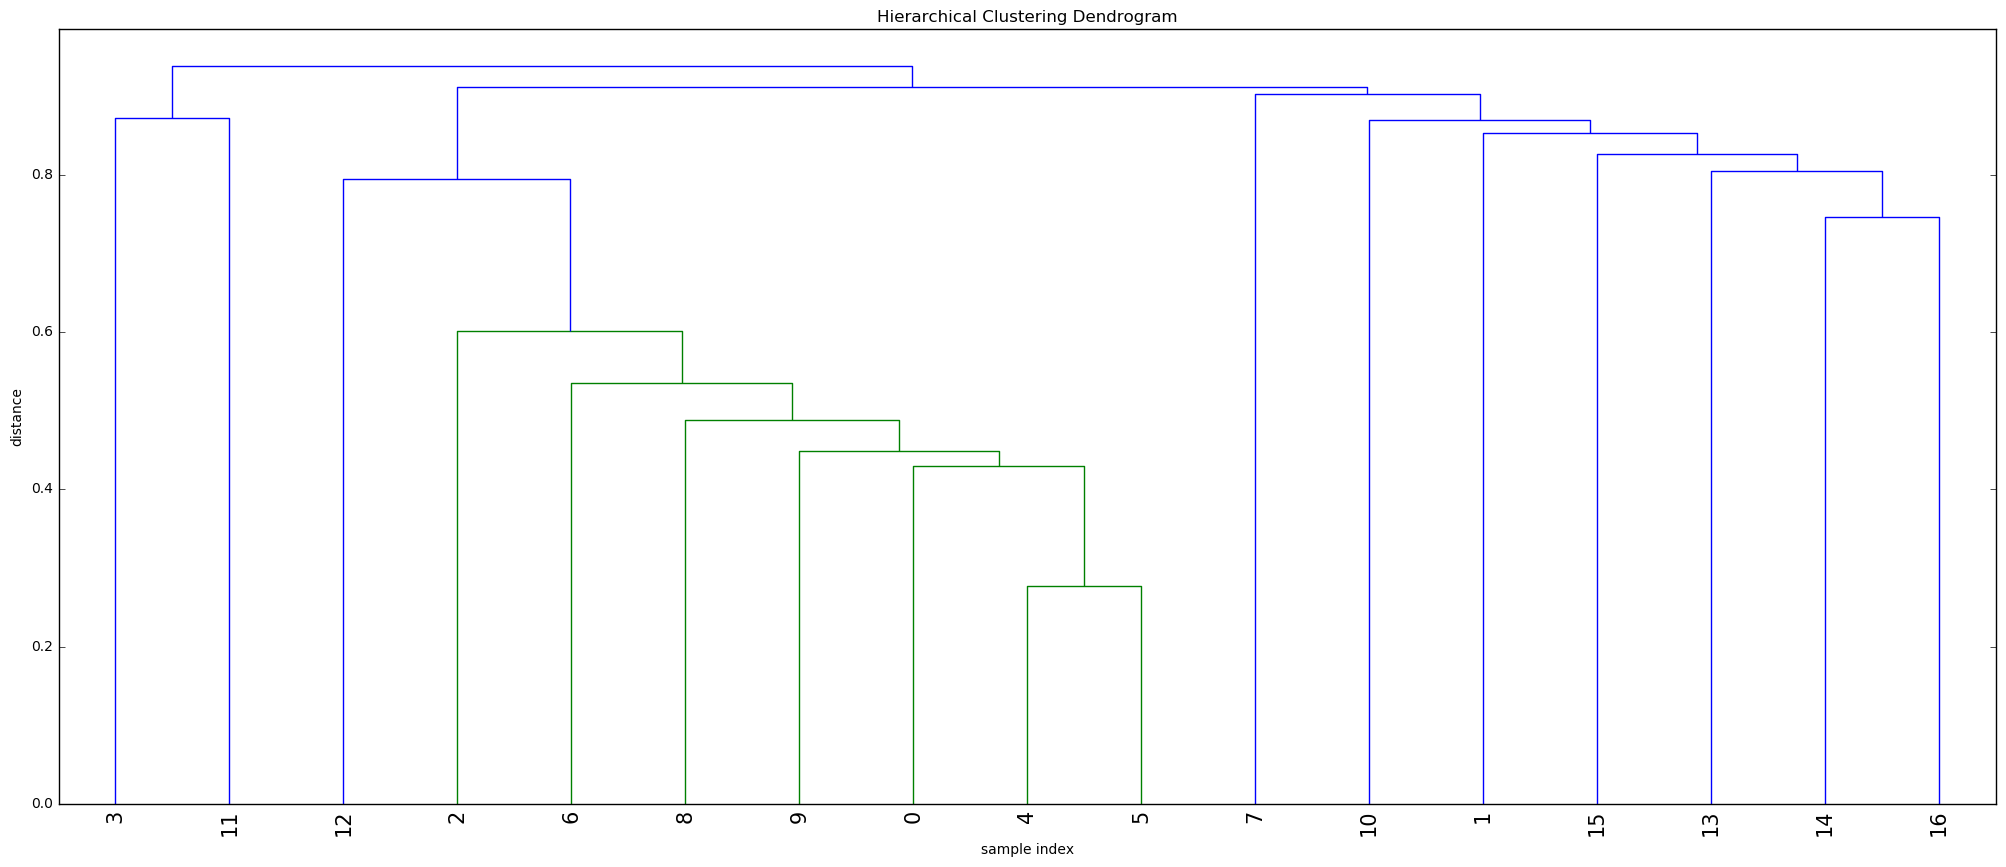

id| True | Pred | Sentence
0 | 0    | 2    | UNK be with that experience in mind that the iconic south african leader , now 85 year old , slowly walk into a crowded news conference at the 15th international aids conference thursday to endorse a new initiative to battle the dual epidemic of tuberculosis and hiv .
1 | 1    | 2    | and why UNK be silently swallow the new kerry deference toward the principle of pre - emptive war .
2 | 0    | 2    | sixteen year ago , while imprison by the south african government , nelson mandela become seriously ill with tuberculosis .
3 | 1    | 1    | and why clinton welfare reformer be willing to abandon hope of a hillary restoration next time around .
4 | 0    | 2    | `` UNK can not win the battle against aids if UNK do not also fight tb , '' mandela say .
5 | 0    | 2    | `` tb be too often a death sentence for people with aids . ''
6 | 0    | 2    | UNK break immune system make UNK vulnerable to the tb bacterium , which attack and scar lung tissu

In [106]:
demo_evaluation(scdv)